In [ ]:
# This is research code I compliled for analysis of ptychography images reconstructed with PtyPy (https://ptycho.github.io/ptypy/)
# specifically for data collected at i08-1 beamline of the Diamond Light Source and is by no means complete. This is however not 
# limited to just ptycho reconstructions but can in general be used for analysis of images. Some parts of the code may use CPU 
# parallelization routines. I do not hold any responsiblity and liability for the use of this code. Feel free to modify and edit this code to your usecase.
# Questions, suggestions and bugs can be reported to jeffrey.neethirajan@cpfs.mpg.de (or stalk me in the internet ;))

## Importing Modules

In [1]:
%reset -f
import os
import skimage
import h5py
import time
import pynx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import h, c, pi, e, hbar, physical_constants
from skimage.registration import phase_cross_correlation
from skimage.segmentation import chan_vese
from skimage.filters import threshold_multiotsu
from scipy.ndimage import fourier_shift
from pynx.utils import fourier_shell_correlation
from ptypy.utils.plot_utils import rmphaseramp
from joblib import Parallel, delayed
from ipywidgets import interactive

## Defining Functions

In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
plt.rcParams["figure.figsize"] = (8, 6)

def plot_img(data, y_range=(0, -1), x_range=(0, -1), cmap='RdBu', threshold=(None, None), title = None):
    """ Function to plot an image """
    %matplotlib inline
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    im1 = ax1.imshow(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], cmap=cmap, vmin=threshold[0], vmax=threshold[-1])
    # plt.axvline(200, color = 'g')
    plt.axis('off')
    if title != None:
        ax1.set_title(title, fontsize=15)
    plt.colorbar(im1, ax=ax1)
    plt.show()
    plt.close()

def single_plot_img(data, y_range=(0, -1), x_range=(0, -1), cmap='RdBu', threshold=(None, None), title = None):
    """ Function to plot an image """
    %matplotlib widget
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    im1 = ax1.imshow(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], cmap=cmap, vmin=threshold[0], vmax=threshold[-1])
    if title != None:
        ax1.set_title(title)
    plt.colorbar(im1, ax=ax1)
    plt.ioff()
    plt.show()


def crop_img(data, y_range=(0, -1), x_range=(0, -1), num_of_img=1):
    """ Function to crop array (images) """
    if num_of_img==1:
        return data[y_range[0]:y_range[1], x_range[0]:x_range[-1]] 
    else:
        cropped_img = []
        for i in range(0, num_of_img):
            y = data[i][y_range[0]:y_range[1], x_range[0]:x_range[-1]]
            cropped_img.append(y)
        return np.array(cropped_img)

def alignment(data, reference,num_of_img=1):
    """ Function to align two images. Sub-pixel image registration is done. Shifts are applied in Fourier Space.
    Returns aligned image and the shift applied """
    aligned_image = []
    shifts = []
    if num_of_img==1:
        s, error, diffphase = phase_cross_correlation(reference_image=reference, moving_image=data, upsample_factor=20, space='real')
        fft_img = np.fft.fftn(data)
        r = fourier_shift(fft_img, s)
        real_img = np.fft.ifftn(r)
        aligned_image.append(real_img)
        shifts.append(s)
    elif num_of_img>1:
        for i in range (0, num_of_img):
            s, error, diffphase = phase_cross_correlation(reference_image=reference, moving_image=data[i], upsample_factor=20, space='real')
            fft_img = np.fft.fftn(data[i])
            r = fourier_shift(fft_img, s)
            real_img = np.fft.ifftn(r)
            aligned_image.append(real_img)
            shifts.append(s)
    return aligned_image, shifts   #changed np.asarray

def norm(data, y_range=(0,-1), x_range=(0,-1), num_of_img=1, dtype='amplitude'):
    """ Function to normalise data """
    norm_factor = []
    norm_data = []
    if num_of_img == 1:
        n = np.average(data[y_range[0]:y_range[1], x_range[0]:x_range[1]])
        norm_factor = n
        if dtype=='amplitude':
            return data / norm_factor
        else:
            return data - norm_factor
    elif num_of_img>1:
        for i in range (0, num_of_img):
            n = np.average(data[i][y_range[0]:y_range[1], x_range[0]:x_range[1]])
            # norm_factor.append(n)
            if dtype == 'amplitude':
                a = data[i] / n
                norm_data.append(a)
            elif dtype == 'phase':
                a = data[i] - n
                norm_data.append(a)
        return np.array(norm_data)    

def local_threshold(data, std_weight_factor=2):
    """ Function returns threshold values based on average and standard deviation """
    w1 = np.average(data)
    w2 = np.std(data)
    return w1 - std_weight_factor*w2, w1 + std_weight_factor*w2

def remove_phase_ramp(data, mask, num_of_img=1):
    """ Function to remove phase ramp"""
    if num_of_img == 1:
        q1 = rmphaseramp(data, weight=mask)
    else:
        q1 = [rmphaseramp(data[i], weight=mask) for i in range (0, num_of_img)]
    return np.asarray(q1)

def segmentation(data, y_range=(0, -1), x_range=(0, -1), circle=True, circle_y_range=(75, 100), circle_x_range=(25, 50), mu=0.05):
    """ Function to segment an image based on the chan vese algorithm. Can only be applied on arrays with real values"""
    labels = chan_vese(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], mu=mu, init_level_set='checkerboard', dt=0.5)
    if circle==True:
        if np.average(labels[circle_y_range[0]:circle_y_range[1], circle_x_range[0]:circle_x_range[1]])==1:
            labels = 1-labels
    return labels

def fft_shift_array(data, shift):
    """ Function that shifts array in fourier space"""
    fft_img = np.fft.fftn(data)
    r = fourier_shift(fft_img, shift[0])
    # r = fourier_shift(fft_img, shift)
    shifted_real_img = np.fft.ifftn(r)
    return shifted_real_img  #changed npasarray


### Loading and preprocessing data

In [5]:
rcp_file = h5py.File(r'FeGd_spectroptycho_data/FeGd_1000nm_complex.nxs', 'r')
rcp_data = np.array(rcp_file['entry1/Counter1/data'])
rcp_energy = np.array(rcp_file['entry1/Counter1/photon_energy'])
rcp_crop = crop_img(rcp_data, y_range=(100,-100), x_range=(100,-100), num_of_img=len(rcp_energy))


rcp_file.close()

rcp_amp = np.abs(rcp_crop)


#### Phase ramp

In [6]:
d1 = []
d2 = []

for i in range (0, len(rcp_energy)):
    d_mask = np.zeros(rcp_amp[1].shape, dtype=bool)
    d_mask[350:1000,400:1400]= True
    
    rcp_corr = remove_phase_ramp(data=rcp_crop[i], mask=d_mask, num_of_img=1)
    d1.append(rcp_corr)
tmp = np.asarray(d1)

d1 = []
# second iteration
for i in range (0, len(rcp_energy)):
    rcp_corr = remove_phase_ramp(data=tmp[i], mask=d_mask, num_of_img=1)
    d1.append(rcp_corr)
tmp = np.asarray(d1)

d1 = []
# third iteration
for i in range (0, len(rcp_energy)): #second iteration of phase ramp removal
    rcp_corr = remove_phase_ramp(data=tmp[i], mask=d_mask, num_of_img=1)
    d1.append(np.angle(rcp_corr))
    
rcp_phase_raw = np.asarray(d1)


#### Alignment

##### First Iteration

In [7]:
cores = -3
d1 = []
d2 = []
d3 = []
for i in range (0, len(rcp_energy)):
    tmp_thresh = threshold_multiotsu(rcp_amp[i,1200:1500,650:1100], classes=3, nbins=512)
    tmp_mask = rcp_amp[i, 1200:1500,550:1200] > tmp_thresh[0]
    d1.append(tmp_mask)
seg = np.asarray(d1)
seg_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=seg[1]) for k in seg)
seg_shift = [i[1] for i in seg_align]
aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(rcp_amp, seg_shift))
d2.append(aligned)
d3.append(seg_shift)
rcp_stack_aligned = np.asarray(d2)
rcp_stack_shifts = np.asarray(d3)

d1 = []
for i in range(0, len(rcp_energy)):
    align_1 = fft_shift_array(data=rcp_phase_raw[i], shift=rcp_stack_shifts[0, i])
    d1.append(align_1.real)
rcp_phase_aligned = np.asarray(d1)


##### Second Iteration

In [8]:
cores = -3
d1 = []
d2 = []
d3 = []

for i in range (0, len(rcp_energy)):
    tmp_thresh = threshold_multiotsu(rcp_stack_aligned[0,i,1200:1500,650:1100].real, classes=3, nbins=512)
    tmp_mask = rcp_stack_aligned[0, i, 1200:1500,550:1200].real > tmp_thresh[0]
    d1.append(tmp_mask)
seg = np.asarray(d1)
seg_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=seg[1]) for k in seg)
seg_shift = [i[1] for i in seg_align]
aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(rcp_stack_aligned[0].real, seg_shift))
d2.append(aligned)
d3.append(seg_shift)
rcp_stack_aligned = np.asarray(d2)
rcp_stack_shifts = np.asarray(d3)

d1 = []
for i in range(0, len(rcp_energy)):
    align_1 = fft_shift_array(data=rcp_phase_aligned[i], shift=rcp_stack_shifts[0, i])
    d1.append(align_1.real)
rcp_phase_aligned = np.asarray(d1)


#### pre-edge normalisation

In [9]:
tmp = rcp_stack_aligned[0].real
d1 = []
d2 = []
norm_factor = np.mean(tmp[0:2,400:1200, 800:1300])
for i in range(0, len(rcp_energy)):
    o1 = tmp[i]/norm_factor
    d1.append(o1)
norm_rcp_stack_aligned = np.asarray(d1)

In [10]:
tmp = rcp_phase_aligned
d1 = []
norm_factor = np.mean(tmp[0:2,400:1200, 800:1300])
for i in range(0, len(rcp_energy)):
    o1 = tmp[i]-norm_factor
    d1.append(o1)
norm_rcp_phase_aligned = np.asarray(d1)

#### Gauss Filter

In [11]:
log_rcp_amp_aligned = np.log(norm_rcp_stack_aligned)
d1 = []
d2 = []
for i in range(0, len(rcp_energy)):
    i1 = skimage.filters.gaussian(log_rcp_amp_aligned[i,400:1200,800:1300], sigma=20)
    o1 = log_rcp_amp_aligned[i,400:1200,800:1300] - i1
    d1.append(o1)
log_rcp_amp_xmcd = np.asarray(d1)

d1 = []
for i in range(0, len(rcp_energy)):
    i1 = skimage.filters.gaussian(norm_rcp_phase_aligned[i, 400:1200, 800:1300], sigma=20)
    o1 = norm_rcp_phase_aligned[i, 400:1200, 800:1300] - i1
    d1.append(o1)
rcp_phase_xmcd = np.asarray(d1)

#### Averaging domains

In [13]:
log_rcp_amp_aligned = np.log(norm_rcp_stack_aligned)
d1 = []
d2 = []
d3 = []
d4 = []

for i in range (0, len(rcp_energy)):
    s1 = np.mean(log_rcp_amp_aligned[i,400:1200,800:1300])
    d1.append(s1)
    a1 = log_rcp_amp_aligned[i,400:1200,800:1300] - s1
    d2.append(a1)
    s2 = np.mean(norm_rcp_phase_aligned[i,400:1200,800:1300])
    d3.append(s2)
    a2 = norm_rcp_phase_aligned[i,400:1200,800:1300] - s2
    d4.append(a2)
    
rcp_amp_elec_log = np.asarray(d1)
log_rcp_amp_xmcd = np.asarray(d2)
rcp_phase_elec = np.asarray(d3)
rcp_phase_xmcd = np.asarray(d4)



d1 = []
d2 = []
tmp = log_rcp_amp_xmcd
for i in range(0, len(rcp_energy)):       
    i1 = skimage.filters.gaussian(image=tmp[i], sigma=20)
    o1 = tmp[i]- i1
    d1.append(o1)
    d2.append(i1)
log_rcp_amp_xmcd = np.asarray(d1)
gaussian_log_rcp_amp_xmcd = np.asarray(d2)

d1 = []
d2 = []
tmp = rcp_phase_xmcd
for i in range(0, len(rcp_energy)):         
    i1 = skimage.filters.gaussian(image=tmp[i], sigma=20)
    o1 = tmp[i]- i1
    d1.append(o1)
    d2.append(i1)
rcp_phase_xmcd = np.asarray(d1)
gaussian_rcp_phase_xmcd = np.asarray(d2)

### Spectra

In [14]:
pos_rcp = segmentation(rcp_phase_xmcd[11])
neg_rcp = 1 - pos_rcp



d1 = []
d2 = []
d3 = []
d4 = []


s1 = []
s2 = []
s3 = []
s4 = []

for i in range(0,len(rcp_energy)):
    if i==13:
        tmp_pos_rcp = segmentation(rcp_phase_xmcd[13]) # for some reason it segments inverted
        tmp_neg_rcp = 1 - tmp_pos_rcp
        b1 = rcp_phase_xmcd[i,0:-1,0:-1] * tmp_pos_rcp 
        spec1 = np.mean(b1[b1!=0])
        d1.append(spec1)
        std1 = b1[b1!=0].std()
        s1.append(std1)

        b2 = rcp_phase_xmcd[i,0:-1,0:-1] * tmp_neg_rcp
        spec2 = np.mean(b2[b2!=0])
        d2.append(spec2)
        std2 = b2[b2!=0].std()
        s2.append(std2)

        b3 = log_rcp_amp_xmcd[i,0:-1,0:-1] * tmp_pos_rcp 
        spec3 = np.mean(b3[b3!=0])
        d3.append(spec3)
        std3 = b3[b3!=0].std()
        s3.append(std3)

        b4 = log_rcp_amp_xmcd[i,0:-1,0:-1] * tmp_neg_rcp 
        spec4 = np.mean(b4[b4!=0])
        d4.append(spec4)
        std4 = b4[b4!=0].std()
        s4.append(std4)
    elif i==12:
        tmp_neg_rcp = segmentation(rcp_phase_xmcd[12])  
        tmp_pos_rcp = 1 - tmp_neg_rcp
        b1 = rcp_phase_xmcd[i,0:-1,0:-1] * tmp_pos_rcp 
        spec1 = np.mean(b1[b1!=0])
        d1.append(spec1)
        std1 = b1[b1!=0].std()
        s1.append(std1)

        b2 = rcp_phase_xmcd[i,0:-1,0:-1] * tmp_neg_rcp
        spec2 = np.mean(b2[b2!=0])
        d2.append(spec2)
        std2 = b2[b2!=0].std()
        s2.append(std2)

        b3 = log_rcp_amp_xmcd[i,0:-1,0:-1] * tmp_pos_rcp 
        spec3 = np.mean(b3[b3!=0])
        d3.append(spec3)
        std3 = b3[b3!=0].std()
        s3.append(std3)

        b4 = log_rcp_amp_xmcd[i,0:-1,0:-1] * tmp_neg_rcp 
        spec4 = np.mean(b4[b4!=0])
        d4.append(spec4)
        std4 = b4[b4!=0].std()
        s4.append(std4)
    else:
        b1 = rcp_phase_xmcd[i,0:-1,0:-1] * pos_rcp 
        spec1 = np.mean(b1[b1!=0])
        d1.append(spec1)
        std1 = b1[b1!=0].std()
        s1.append(std1)

        b2 = rcp_phase_xmcd[i,0:-1,0:-1] * neg_rcp
        spec2 = np.mean(b2[b2!=0])
        d2.append(spec2)
        std2 = b2[b2!=0].std()
        s2.append(std2)

        b3 = log_rcp_amp_xmcd[i,0:-1,0:-1] * pos_rcp 
        spec3 = np.mean(b3[b3!=0])
        d3.append(spec3)
        std3 = b3[b3!=0].std()
        s3.append(std3)

        b4 = log_rcp_amp_xmcd[i,0:-1,0:-1] * neg_rcp 
        spec4 = np.mean(b4[b4!=0])
        d4.append(spec4)
        std4 = b4[b4!=0].std()
        s4.append(std4)

    
single_pol_rcp_xmcd_pos_phase = np.asarray(d1)
single_pol_rcp_xmcd_neg_phase = np.asarray(d2)
single_pol_rcp_xmcd_pos_amp = np.asarray(d3)
single_pol_rcp_xmcd_neg_amp = np.asarray(d4)

mask_std_rcp_xmcd_pos_amp = np.asarray(s3)
mask_std_rcp_xmcd_neg_amp = np.asarray(s4)
mask_std_rcp_xmcd_pos_phase = np.asarray(s1)
mask_std_rcp_xmcd_neg_phase = np.asarray(s2)


#### Amplitude

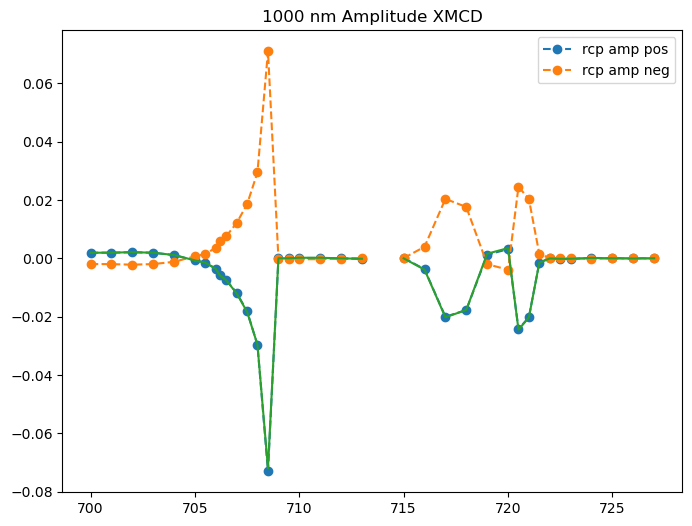

In [15]:
%matplotlib inline
plt.close()
plt.plot(rcp_energy, single_pol_rcp_xmcd_pos_amp,'o--',label='rcp amp pos')
plt.plot(rcp_energy, single_pol_rcp_xmcd_neg_amp,'o--',label='rcp amp neg')
plt.plot(rcp_energy, (single_pol_rcp_xmcd_pos_amp - single_pol_rcp_xmcd_neg_amp)/2)
# plt.plot(rcp_energy, (mask_std_rcp_xmcd_pos_amp + mask_std_rcp_xmcd_neg_amp)/2)
plt.title('1000 nm Amplitude XMCD')
# plt.ylabel('')
plt.legend()
plt.show()

#### Phase

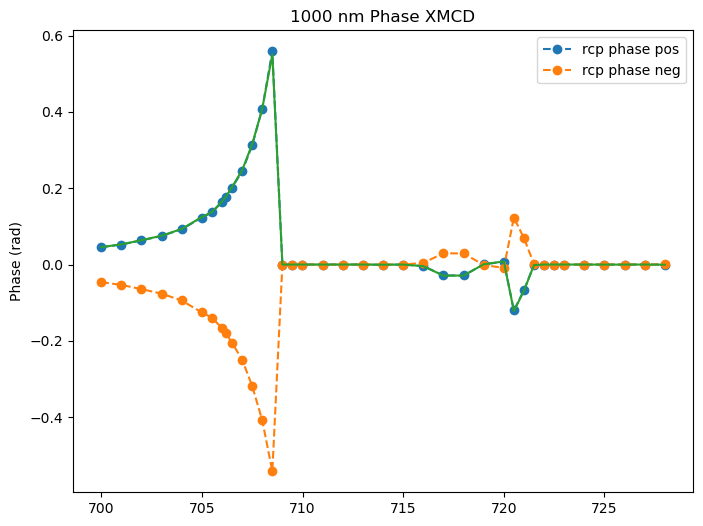

In [18]:
plt.plot(rcp_energy, single_pol_rcp_xmcd_pos_phase,'o--',label='rcp phase pos')
plt.plot(rcp_energy, single_pol_rcp_xmcd_neg_phase,'o--',label='rcp phase neg')
plt.plot(rcp_energy, (single_pol_rcp_xmcd_pos_phase - single_pol_rcp_xmcd_neg_phase)/2)

plt.title('1000 nm Phase XMCD')
plt.ylabel('Phase (rad)')
plt.legend()
plt.show()

#### Transmission

In [19]:
d1=[]
for i in range (0, len(rcp_energy)):
    spec1 = np.mean(np.log(norm_rcp_stack_aligned[i,400:1200,800:1300]))
    d1.append(spec1)
elec_spec = np.exp(np.asarray(d1))
transmission_spec = elec_spec**2

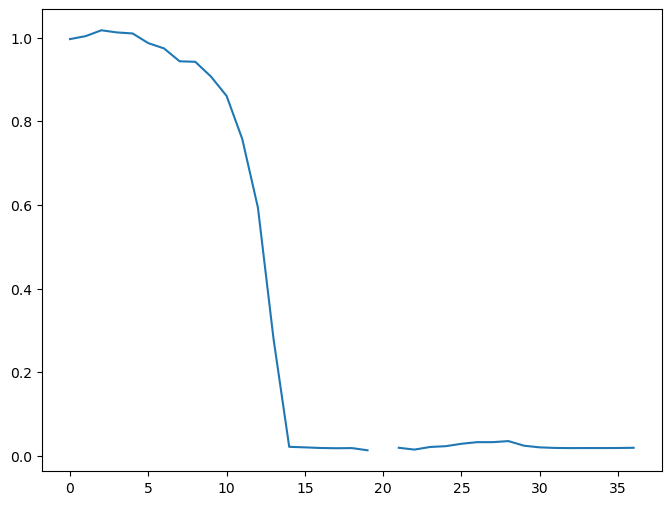

In [20]:
plt.plot(transmission_spec)

#### Errorbar by splitting image

In [21]:
pos_rcp[:-9,:-9].shape

(790, 490)

In [22]:
d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []


s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []

    
split_pos_rcp = np.split(pos_rcp[:-19,:-19], 4, axis=0)
split_neg_rcp = np.split(neg_rcp[:-19,:-19], 4, axis=0)


for i in range (0, len(rcp_energy)):
    split_img_1 = np.split(log_rcp_amp_xmcd[i,:-20,:-20], 4, axis=0)
 
    split_img_3 = np.split(rcp_phase_xmcd[i,:-20,:-20], 4, axis=0)

    for j in range (0,4):
        b1 = split_img_1[j] * split_pos_rcp[j]
        spec1 = np.mean(b1[b1!=0])
        s1.append(spec1)
        b2 = split_img_1[j] * split_neg_rcp[j]
        spec2 = np.mean(b2[b2!=0])
        s2.append(spec2)
        b5 = split_img_3[j] * split_pos_rcp[j]
        spec5 = np.mean(b5[b5!=0])
        s5.append(spec5)
        b6 = split_img_3[j] * split_neg_rcp[j]
        spec6 = np.mean(b6[b6!=0])
        s6.append(spec6)

        
    tmp1 = np.asarray(s1)
    tmp2 = np.asarray(s2)
    tmp3 = np.asarray(s3)
    tmp4 = np.asarray(s4)
    tmp5 = np.asarray(s5)
    tmp6 = np.asarray(s6)
    tmp7 = np.asarray(s7)
    tmp8 = np.asarray(s8)
    
four_spectra_rcp_amp_pos = tmp1.reshape(len(rcp_energy),4)
four_spectra_rcp_amp_neg = tmp2.reshape(len(rcp_energy),4)

four_spectra_rcp_phase_pos = tmp5.reshape(len(rcp_energy),4)
four_spectra_rcp_phase_neg = tmp6.reshape(len(rcp_energy),4)


split_spectra_log_rcp_amp_pos = np.asarray(np.split(four_spectra_rcp_amp_pos, 4, axis=1))
split_spectra_log_rcp_amp_neg = np.asarray(np.split(four_spectra_rcp_amp_neg, 4, axis=1))

split_spectra_rcp_phase_pos = np.asarray(np.split(four_spectra_rcp_phase_pos, 4, axis=1))
split_spectra_rcp_phase_neg = np.asarray(np.split(four_spectra_rcp_phase_neg, 4, axis=1))


mean_split_spectra_log_rcp_amp_pos = np.mean(split_spectra_log_rcp_amp_pos, axis=0)
mean_split_spectra_log_rcp_amp_neg = np.mean(split_spectra_log_rcp_amp_neg, axis=0)

mean_split_spectra_rcp_phase_pos = np.mean(split_spectra_rcp_phase_pos, axis=0)
mean_split_spectra_rcp_pahse_neg = np.mean(split_spectra_rcp_phase_neg, axis=0)


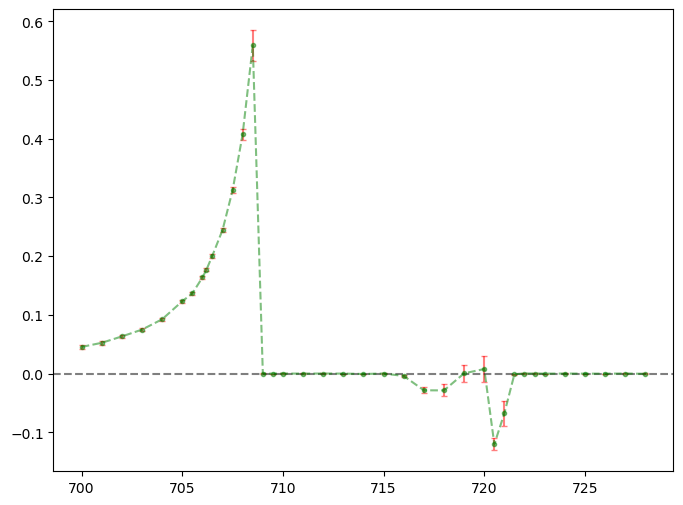

In [23]:
phase_err1 = np.std(split_spectra_rcp_phase_pos, axis=0)
phase_err2 = np.std(split_spectra_rcp_phase_neg, axis=0)


amp_err1 = np.std(split_spectra_log_rcp_amp_pos, axis=0)
amp_err2 = np.std(split_spectra_log_rcp_amp_neg, axis=0)


split_amp_error = np.asarray([amp_err1, amp_err2])
split_phase_error = np.asarray([phase_err1, phase_err2])
split_avg_amp_error = np.mean(split_amp_error, axis=0)
split_avg_phase_error = np.mean(split_phase_error,axis=0)
plt.errorbar(rcp_energy, single_pol_rcp_xmcd_pos_phase, yerr=split_avg_phase_error[:,0], color='g', marker='.', linestyle='--', capsize=2, ecolor='r', label='Phase', alpha=0.5)

plt.axhline(0,ls='--',color='k',alpha=0.5)
plt.show()

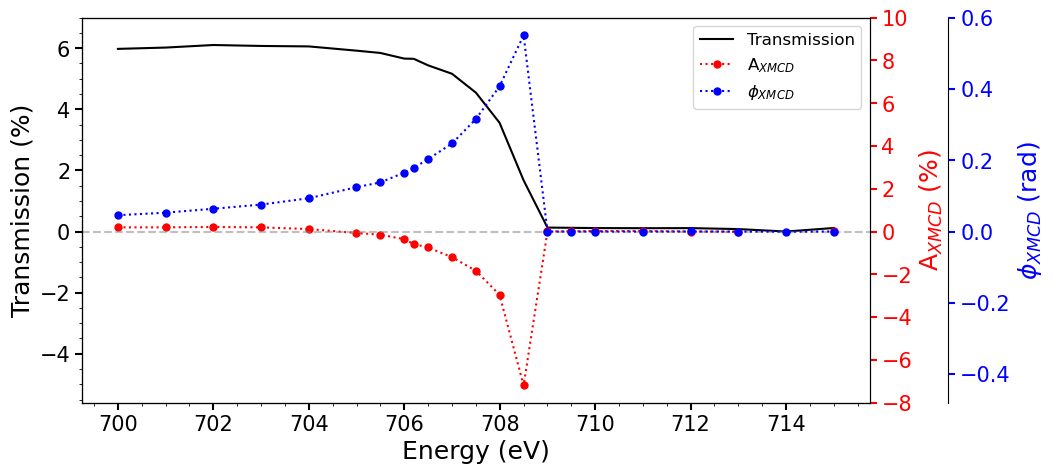

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,5))
fig.subplots_adjust(right=1)

twin1 = ax.twinx()
twin2 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.1))
k=22
p1, = ax.plot(rcp_energy[:k], 0.06 * np.nan_to_num(transmission_spec[:k])*100, color='k', ls="-", label="Transmission")
p2, = twin1.plot(rcp_energy[:k], (single_pol_rcp_xmcd_pos_amp[:k] - single_pol_rcp_xmcd_neg_amp[:k])/2*100, color='red', marker='.', linestyle=':', label='A$_{XMCD}$', alpha=1, markersize=10)
p3, = twin2.plot(rcp_energy[:k], (single_pol_rcp_xmcd_pos_phase[:k] - single_pol_rcp_xmcd_neg_phase[:k])/2, color='blue', marker='.', linestyle=':', label='$\phi_{XMCD}$', alpha=1, markersize=10)



ax.set_ylim(-5.6, 7)
twin1.set_ylim(-8, 10)
twin2.set_ylim(-0.48,0.6)

ax.set_xlabel("Energy (eV)", fontsize=18)
ax.set_ylabel("Transmission (%)", fontsize=18)
twin1.set_ylabel("A$_{XMCD}$ (%)", fontsize=18)
twin2.set_ylabel("$\phi_{XMCD}$ (rad)", fontsize=18)

twin1.axhline(0, color='gray', ls='--', alpha=0.5)

transparency = 0.4
c = 'k'


ax.yaxis.label.set_color('k')
twin1.yaxis.label.set_color('red')
twin2.yaxis.label.set_color('blue')
ax.minorticks_on()

tkw = dict(size=5, width=1.5, labelsize=15)
ax.tick_params(axis='y', colors='k', **tkw)
twin1.tick_params(axis='y', colors='red', **tkw)
twin2.tick_params(axis='y', colors='blue', **tkw)
ax.tick_params(axis='x', **tkw)
ax.legend(handles=[ p1, p2, p3], fontsize=12) #, p4, p5
plt.show()

## Noise analysis

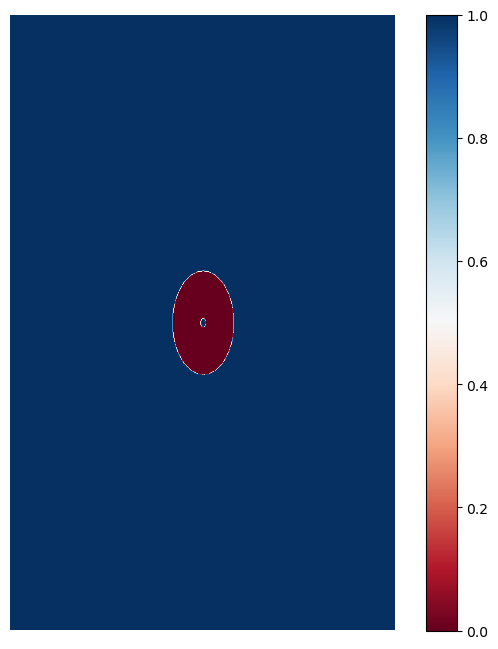

In [26]:
def ellipse_mask(img, radius=5, semi_major_axis=6, semi_minor_axis=30, angle=0):
    wx,wy = img.shape
    xx,yy = np.meshgrid(np.arange(wy)-wy//2, np.arange(wx)-wx//2)
    rr = np.sqrt((xx*np.cos(np.radians(angle)) + yy*np.sin(np.radians(angle)))**2/semi_major_axis + (yy*np.cos(np.radians(angle)) + xx*np.sin(np.radians(angle)))**2/semi_minor_axis)
    mask = (rr>radius)
    return mask


def ring_ellipse_mask(img, inner_radius=2, outer_radius=4, semi_major_axis=6, semi_minor_axis=30):
    wx,wy = img.shape
    xx,yy = np.meshgrid(np.arange(wy)-wy//2, np.arange(wx)-wx//2)
    rr = np.sqrt(xx**2/semi_major_axis + yy**2/semi_minor_axis)
    mask1 = rr>outer_radius
    mask2 = rr<inner_radius
    mask = mask1 + mask2
    return mask

test_mask = ring_ellipse_mask(log_rcp_amp_xmcd[23], outer_radius=15, inner_radius=1.3, semi_major_axis=7, semi_minor_axis=20)
plot_img(test_mask)

In [27]:

img1 = rcp_phase_xmcd[13]
fft_img1 = np.fft.fftn(img1)
gauss_img1 = skimage.filters.gaussian(img1, sigma=1)
fft_gauss_img1 = np.fft.fftn(gauss_img1)
diff_img1 = img1 - gauss_img1
fft_diff_img1 = np.fft.fftn(diff_img1)
fourier_diff_img1 = fft_img1 - fft_gauss_img1
real_space_fourier_diff_img1 = np.fft.ifftn(fourier_diff_img1)




mask = np.fft.ifftshift(test_mask)
masked_fft_img1 = (((fft_img1))) * mask


In [29]:

elliptical_mask = np.fft.ifftshift(ring_ellipse_mask(log_rcp_amp_xmcd[23], outer_radius=15, inner_radius=1.3, semi_major_axis=7, semi_minor_axis=20))

d1 = []
d2 = []
for i in range (0, len(rcp_energy)): 
    amp_img = log_rcp_amp_xmcd[i]
    phase_img = rcp_phase_xmcd[i]
    fft_amp_img = np.fft.fftn(amp_img)
    fft_phase_img = np.fft.fftn(phase_img)
    masked_fft_amp_img = fft_amp_img * elliptical_mask
    masked_fft_phase_img = fft_phase_img * elliptical_mask
    noise_amp_img  = np.std(((np.fft.ifftn(masked_fft_amp_img).real[10:-11,10:-11])))
    noise_phase_img = np.std(np.fft.ifftn(masked_fft_phase_img).real[10:-11, 10:-11])
    d1.append(noise_amp_img)
    d2.append(noise_phase_img)
high_freq_noise_log_amp_xmcd = np.asarray(d1)
high_freq_noise_phase_xmcd = np.asarray(d2)

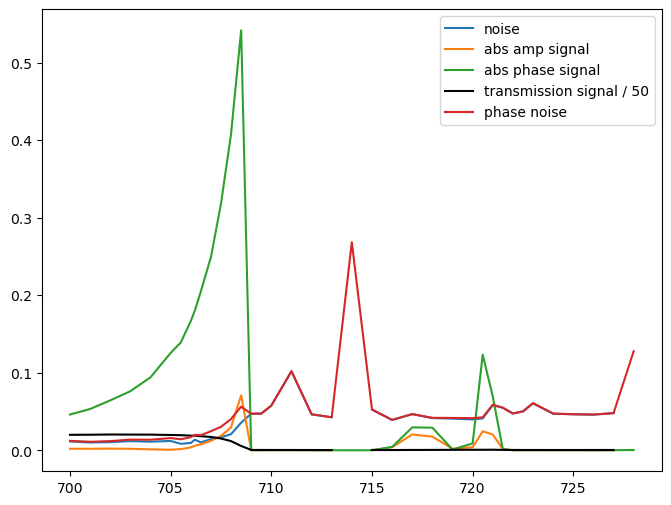

In [30]:
%matplotlib inline
plt.close()
plt.plot(rcp_energy, high_freq_noise_log_amp_xmcd, label='noise')
plt.plot(rcp_energy, np.abs(single_pol_rcp_xmcd_neg_amp), label='abs amp signal')
plt.plot(rcp_energy, np.abs(single_pol_rcp_xmcd_neg_phase), label='abs phase signal')
plt.plot(rcp_energy, np.abs(transmission_spec)/50, 'k', label='transmission signal / 50')
plt.plot(rcp_energy, high_freq_noise_phase_xmcd, label='phase noise')
plt.legend()

## Spatial Resolution

### FRC

#### Amplitude

In [18]:
pixelsize = 11.209
img1 = log_rcp_amp_xmcd[10]
img2 = log_rcp_amp_xmcd[11]
frc_test = fourier_shell_correlation.FourierShellCorr(img1, img2, ring_thick=6, rad_apod=60, axial_apod=20)
y1 = frc_test.fouriercorr()
x1 = frc_test.nyquist()

Input images have 2 dimensions
Using ring_thick = 6
Using SNRt = 0.2071


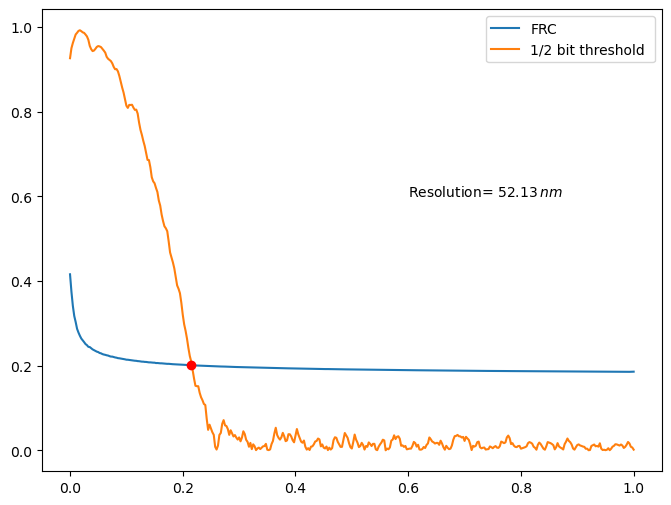

In [20]:
%matplotlib inline
tmp = np.argwhere(np.diff(np.sign(y1[0] - y1[1]))).flatten()
x = x1[0]/x1[1]
resolution = pixelsize / x[tmp[0]]
plt.close()
plt.plot(x1[0]/x1[1], y1[1], label='FRC')
plt.plot(x1[0]/x1[1], y1[0], label='1/2 bit threshold ')
plt.plot(x[tmp[0]], y1[1][tmp[0]], 'ro')
plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution))
# plt.title('Amplitude resonance RCP')
plt.legend()
plt.show()

In [21]:
pixelsize = 11.209
img1 = rcp_phase_xmcd[10]
img2 = rcp_phase_xmcd[11]
frc_test = fourier_shell_correlation.FourierShellCorr(img1, img2,ring_thick=6, rad_apod=60, axial_apod=20)
y1 = frc_test.fouriercorr()
x1 = frc_test.nyquist()

Input images have 2 dimensions
Using ring_thick = 6
Using SNRt = 0.2071


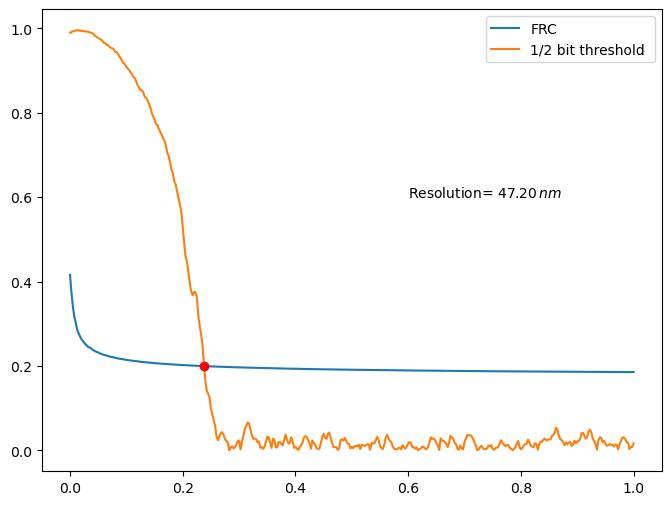

In [23]:
%matplotlib inline
tmp = np.argwhere(np.diff(np.sign(y1[0] - y1[1]))).flatten()
x = x1[0]/x1[1]
resolution = pixelsize / x[tmp[0]]
plt.close()
plt.plot(x1[0]/x1[1], y1[1], label='FRC')
plt.plot(x1[0]/x1[1], y1[0], label='1/2 bit threshold ')
plt.plot(x[tmp[0]], y1[1][tmp[0]], 'ro')
plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution))
# plt.title('Amplitude resonance RCP')
plt.legend()
plt.show()